In [29]:
import os
import pandas as pd
import numpy as np
import joblib
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(5,5)})

In [10]:
%load_ext autoreload
%autoreload 2

import experiments_utils
from mlexpies import neighborhood

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
STORE_DATA_FOLDER = 'experiments/adult/'

def load_exported_data(name):
    return joblib.load(os.path.join(STORE_DATA_FOLDER, name))

folds_data = load_exported_data('folds.bz2')

# Load data

In [4]:
sf_regression_base_raw = load_exported_data('sf_clasification_base@sgower.bz2')
sf_regression_base = pd.DataFrame(experiments_utils.extract_anchor_explanations(sf_regression_base_raw))

In [5]:
sf_regression_res_raw = load_exported_data('sf_clasification_restrict@sgower.bz2')
sf_regression_res = pd.DataFrame(experiments_utils.extract_anchor_explanations(sf_regression_res_raw))

In [6]:
cc_cls_base_raw = load_exported_data('cc_clasification_base@sgower.bz2')
cc_cls_base = pd.DataFrame(experiments_utils.extract_counterfactual_explanations(cc_cls_base_raw))
cc_cls_base['round_actual'] = (cc_cls_base['actual'] > 0.5).astype(int)
cc_cls_base.set_index('sample_idx', inplace=True)

In [7]:
cc_cls_res_raw = load_exported_data('cc_clasification_restrict@sgower.bz2')
cc_cls_res = pd.DataFrame(experiments_utils.extract_counterfactual_explanations(cc_cls_res_raw))
cc_cls_res['round_actual'] = (cc_cls_res['actual'] > 0.5).astype(int)
cc_cls_res.set_index('sample_idx', inplace=True)

In [8]:
cs_cls_base_raw = load_exported_data('cs_clasification_base@sgower.bz2')
cs_cls_base = pd.DataFrame(experiments_utils.extract_anchor_explanations(cs_cls_base_raw))
cs_cls_base['prediction'] = (1 + cs_cls_base['prediction']) % 2

In [9]:
cs_cls_res_raw = load_exported_data('cs_clasification_restrict@sgower.bz2')
cs_cls_res = pd.DataFrame(experiments_utils.extract_anchor_explanations(cs_cls_res_raw))
cs_cls_res['prediction'] = (1 + cs_cls_res['prediction']) % 2

# Co-ocurrence figure

In [10]:
columns_order = ['Age', 'Workclass', 'Education', 'MaritalStatus', 'Occupation',
       'Relationship', 'Race', 'Sex', 'CapitalGain', 'CapitalLoss',
       'HoursPerWeek']

In [65]:
from matplotlib import colors

cmap = colors.ListedColormap(sns.color_palette("colorblind").as_hex())

def plot_cc_combs(df, title, top=5, columns_order=None, include_x_labels=True, ax=None):
    df = df.copy()
    ccs = df['counterfacutal'].apply(pd.Series)
    ccos = df['observation'].apply(pd.Series)[ccs.columns]
    diff = abs(ccs - ccos) > 0.1
    most_common = diff.groupby(df['round_actual']).apply(lambda x: x.value_counts().head(top) / len(x))
    cc_most_common_pattern = most_common.reset_index()
    cc_most_common_pattern.rename(columns={0:'counts'}, inplace=True)
    cc_matrix = cc_most_common_pattern

    cc_matrix = cc_matrix.replace(False, 0.0)
    cc_matrix = cc_matrix.replace(True, 1.0)
    cc_matrix.loc[cc_matrix['round_actual'] == 1] = cc_matrix.loc[cc_matrix['round_actual'] == 1].replace(1.0, 0.5)
    cc_matrix = cc_matrix.sort_values(by='counts', ascending=False)
    cc_counts = cc_matrix['counts']
    cc_matrix = cc_matrix.drop(columns=['round_actual', 'counts'])
    
    if columns_order is not None:
        cc_matrix = cc_matrix[[col for col in columns_order if col in cc_matrix.columns]]
        
    g = sns.heatmap(cc_matrix, ax=ax, cbar=False, xticklabels=cc_matrix.columns,
                yticklabels=[f'{int(x)}%' for x in round(100 * cc_counts, 0)], linewidths=.5, cmap=colors.ListedColormap(['white', cmap.colors[0], cmap.colors[1]]))
    g.set_xticklabels(labels = g.get_xticklabels(), rotation=90)
    g.set(title=title)
    if not include_x_labels:
        g.set(xticklabels=[])
        
    fig = g.figure
    g.axes.set_title(title, fontsize=10)
    fig.tight_layout()
    return fig

def extract_feat(x):
    if x.count('<') == 2:
        return x.split(' ')[2]
    return x[:x.find(' ')]

def plot_sf_combs(df, title, columns_order, top=5, fixed=(), remove=(), include_x_labels=True, ax=None, cbar=False):
    df = df.copy()
    ccs = df['anchor'].apply(lambda ac: frozenset([extract_feat(x) for x in ac]))
    
    ccs_top_values = []
    for prediction in [0, 1]:
        ccs_pred = ccs[df['prediction'] == prediction]
        top_comb = ccs_pred.value_counts().head(top)
        ccs_top_values.append(ccs_pred[ccs_pred.apply(lambda x: x in top_comb.index) ]) 
    
    ccs_top = pd.concat(ccs_top_values, axis=0)
    ccs_top_matrix = ccs_top.apply(lambda x: pd.Series([(col in x) for col in columns_order], index=columns_order)).fillna(False)
    ccs_top_matrix = ccs_top_matrix.join(df['prediction'], how='inner')
    
    sf_most_common_pattern = ccs_top_matrix.groupby('prediction').apply(lambda x: x.value_counts() / len(x)).reset_index(level=0, drop=True)
    sf_most_common_pattern = sf_most_common_pattern.reset_index()
    sf_most_common_pattern.sort_values(by=0, inplace=True, ascending=False)
    sf_counts = sf_most_common_pattern[0]
    sf_matrix = sf_most_common_pattern.drop(columns=0)
    
    for col in fixed:
        sf_matrix[col] = True
        
    for col in remove:
        sf_matrix[col] = False
    
    sf_matrix = sf_matrix.replace(False, 0)
    sf_matrix = sf_matrix.replace(True, 1)
    sf_matrix.loc[sf_matrix['prediction'] == 1] = sf_matrix.loc[sf_matrix['prediction'] == 1].replace(1.0, 0.5)
    sf_matrix = sf_matrix.drop(columns='prediction')
    
    if columns_order is not None:
        sf_matrix = sf_matrix[[col for col in columns_order if col in sf_matrix.columns]]
        
    g = sns.heatmap(sf_matrix, cbar=cbar, ax=ax, xticklabels=sf_matrix.columns,
                yticklabels=[f'{int(x)}%' for x in round(100 * sf_counts, 0)], linewidths=.5, cmap=colors.ListedColormap(['white', cmap.colors[0], cmap.colors[1]]))
    g.set_xticklabels(labels = g.get_xticklabels(), rotation=90)
    g.set(title=title)
    if not include_x_labels:
        g.set(xticklabels=[])
        
    fig = g.figure
    g.axes.set_title(title, fontsize=11)
    fig.tight_layout()
    return ax, fig

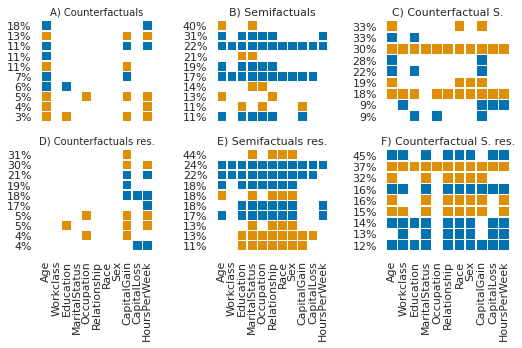

In [66]:
fig, axs = plt.subplots(2, 3, figsize=(7.5, 5)) #gridspec_kw=dict(height_ratios=[2/3, 2/3]))

sample_size=1

fixed_features = ('Race', 'Sex', 'MaritalStatus', 'Relationship')

plot_cc_combs(cc_cls_base, title='A) Counterfactuals', columns_order=columns_order, ax=axs[0, 0], include_x_labels=False)
plot_cc_combs(cc_cls_res, title='D) Counterfactuals res.', columns_order=columns_order, ax=axs[1, 0])

plot_sf_combs(sf_regression_base, title='B) Semifactuals', columns_order=columns_order, ax=axs[0, 1], include_x_labels=False, cbar=False)
plot_sf_combs(sf_regression_res, title='E) Semifactuals res.', columns_order=columns_order, fixed=fixed_features, ax=axs[1, 1])

plot_sf_combs(cs_cls_base, title='C) Counterfactual S.', columns_order=columns_order, ax=axs[0, 2], include_x_labels=False, cbar=False)
plot_sf_combs(cs_cls_res, title='F) Counterfactual S. res.', columns_order=columns_order, fixed=fixed_features, ax=axs[1, 2])


for i in range(2):
    for j in range(3):
        axs[i, j].set_aspect('equal')
        
# Add legend
#colorbar = ax.collections[0].colorbar
#colorbar.set_ticks([0, 0.5, 1])
#colorbar.set_ticklabels(['', '$\leq\$50k$', '$>\$50k$'])

fig.savefig('figures/adult_exps_co.png', dpi=400)

# Neighborhood label representation

In [104]:
def calculate_label_ratios(fast_neighborhood):
    ratios = {0: [], 1: []}
    for fold_id, fold_data in enumerate(tqdm(folds_data, position=0)):
        df = fold_data['df']
        train_idx = fold_data['train_idx']
        dataset_info = fold_data['dataset_info']
        df_train = df.drop(columns=dataset_info.target_column)
        X_train = df_train.loc[train_idx]
        y_train_hat = pd.Series((fold_data['model'].predict(X_train) > 0.5).astype(int))
        
        for train_idx in train_idx:
            sample = X_train.loc[train_idx]
            label = df.loc[train_idx, dataset_info.target_column]
                
            belong_neighborhood_mask =  fast_neighborhood(sample, X_train)
            counts = y_train_hat[belong_neighborhood_mask].value_counts()
            counts_np = np.array([counts[l] if l in counts else 0 for l in ratios.keys()])
            ratios[label].append(counts_np / counts_np.sum())
            
    return ratios


def agg_label(values):
    all_values = np.vstack(values)
    return all_values.sum(axis=0) / len(values)

In [102]:
def fast_belong_base_neighborhood(sample, X_train):
    return np.full(len(X_train), True)

def fast_belong_restricted_neighborhood_factory(fixed):
    def impl(sample, X_train):
        mask = np.zeros(len(X_train))
        
        for feature in fixed:
            mask += (sample[feature] != X_train[feature]).astype(int)
            
        if isinstance(mask, pd.Series):
            mask = mask.values
            
        return mask == 0
    
    return impl

In [105]:
res = calculate_label_ratios(fast_belong_restricted_neighborhood_factory(['Race', 'Sex', 'MaritalStatus', 'Relationship']))

  0%|          | 0/10 [00:00<?, ?it/s]

In [81]:
base = calculate_label_ratios(fast_belong_base_neighborhood)

  0%|          | 0/10 [00:00<?, ?it/s]

In [106]:
agg_label(res[0]), agg_label(res[1])

(array([0.84329059, 0.15670941]), array([0.63006945, 0.36993055]))

In [94]:
agg_label(base[0]), agg_label(base[1])

(array([0.79087405, 0.20912595]), array([0.7908715, 0.2091285]))

# Diversity

In [68]:
cc_cls_div_raw = load_exported_data('cc_div_clasification_base@sgower.bz2')
cc_cls_div = pd.DataFrame(experiments_utils.extract_counterfactual_explanations(cc_cls_div_raw))
cc_cls_div['round_actual'] = (cc_cls_base['actual'] > 0.5).astype(int)
cc_cls_div.set_index('sample_idx', inplace=True)

In [69]:
def generate_distances(base_distance):
    distances = {}
    for fold_id, fold_data in enumerate(folds_data):
        df = fold_data['df']
        train_idx = fold_data['train_idx']
        dataset_info = fold_data['dataset_info']
        df_train = df.drop(columns=dataset_info.target_column)
        X_train = df_train.loc[train_idx]
        distance = base_distance()
        distance.fit(X_train, dataset_info)
        distances[fold_id] = distance
        
    return distances

In [70]:
distances = generate_distances(neighborhood.GowerNeighborhoodDistance)

In [71]:
def calculate_distances(row):
    counterfactual = pd.Series(row['counterfacutal'])
    div_counterfactual = pd.Series(row['div_counterfactual']) 
    observation = pd.Series(row['observation'])
    fold_id = row['fold_id']
    
    distance = distances[fold_id]
    
    cc_div_distance = distance.distance(observation, div_counterfactual)
    cc_base_distance = distance.distance(observation, counterfactual)
    cc_distance = distance.distance(div_counterfactual, counterfactual)
    
    return pd.Series({'div_factual_distance': cc_div_distance, 'base_factual_distance': cc_base_distance, 'diversity': cc_distance})

In [72]:
cc_cls_base_div = cc_cls_div[['fold_id', 'counterfacutal', 'observation']].rename(columns={'counterfacutal':'div_counterfactual'}).join(cc_cls_base[['counterfacutal']], )

In [73]:
cc_cls_base_div_distances = cc_cls_base_div.apply(calculate_distances, axis=1)

In [74]:
table_div = cc_cls_base_div_distances.groupby(cc_cls_div['round_actual']).mean()
table_div

,div_factual_distance,base_factual_distance,diversity
round_actual,,,
0,0.199668,0.123303,0.423072
1,0.197691,0.121310,0.417119


In [72]:
print(table_div.to_latex())

\begin{tabular}{lrrr}
\toprule
{} &  div\_factual\_distance &  base\_factual\_distance &  diversity \\
round\_actual &                       &                        &            \\
\midrule
0            &              0.289220 &               0.197400 &   0.401329 \\
1            &              0.290281 &               0.197848 &   0.403215 \\
\bottomrule
\end{tabular}



In [78]:
(cc_cls_base_div_distances['base_factual_distance'].mean().round(2), cc_cls_base_div_distances['div_factual_distance'].mean().round(2))

(0.12, 0.2)

In [79]:
cc_cls_base_div_distances['diversity'].mean().round(2)

0.42

In [75]:
percentage_change(cc_cls_base_div_distances['base_factual_distance'].mean(), cc_cls_base_div_distances['div_factual_distance'].mean())

62.14

# Anchor and CS table

In [20]:
sf_b = sf_regression_base[['num_conditions', 'own_coverage', 'own_precision', 'prediction']].copy()
sf_r = sf_regression_res[['num_conditions', 'own_coverage', 'own_precision', 'prediction']].copy()
cs_b = cs_cls_base[['num_conditions', 'own_coverage', 'own_precision', 'prediction']].copy()
cs_r = cs_cls_res[['num_conditions', 'own_coverage', 'own_precision', 'prediction']].copy()

sf_b['type'] = 'sf_base'
sf_r['type'] = 'sf_res'
cs_b['type'] = 'cs_base'
cs_r['type'] = 'cs_res'


all_sfs = pd.concat((sf_b, sf_r, cs_b, cs_r))

all_sfs['own_coverage'] = all_sfs['own_coverage'] * 100
all_sfs['own_precision'] = all_sfs['own_precision'] * 100
all_sfs = all_sfs.rename(columns={'own_coverage': 'Coverage (%)', 'own_precision': 'Precision (%)', 'num_conditions': 'Nº conditions'})

In [21]:
def mean_std(x, round_n=2):
    mean = round(x.mean(), round_n)
    std = round(x.std(), round_n)
    
    return f"{mean} ({std})"

In [61]:
tab = all_sfs.groupby(['type', 'prediction']).agg([mean_std])
tab

Nº conditions   Coverage (%)  Precision (%)
                        mean_std       mean_std       mean_std
type    prediction                                            
cs_base 0            7.14 (2.36)    1.03 (1.64)   83.0 (12.57)
        1            3.05 (1.34)  22.33 (13.83)   95.73 (3.89)
cs_res  0            8.33 (2.33)    1.72 (2.72)  59.55 (32.35)
        1            6.95 (2.53)   20.2 (22.51)  83.45 (13.68)
sf_base 0            2.19 (0.64)    15.25 (8.7)    98.3 (1.69)
        1             7.5 (2.34)      0.4 (0.7)  93.33 (10.47)
sf_res  0            3.89 (1.47)  50.86 (37.73)   98.09 (3.37)
        1            6.64 (3.14)    1.15 (1.97)  92.85 (13.48)

In [62]:
print(tab.to_latex())

\begin{tabular}{lllll}
\toprule
       &   & Nº conditions &   Coverage (\%) &  Precision (\%) \\
       &   &      mean\_std &       mean\_std &       mean\_std \\
type & prediction &               &                &                \\
\midrule
cs\_base & 0 &   7.14 (2.36) &    1.03 (1.64) &   83.0 (12.57) \\
       & 1 &   3.05 (1.34) &  22.33 (13.83) &   95.73 (3.89) \\
cs\_res & 0 &   8.33 (2.33) &    1.72 (2.72) &  59.55 (32.35) \\
       & 1 &   6.95 (2.53) &   20.2 (22.51) &  83.45 (13.68) \\
sf\_base & 0 &   2.19 (0.64) &    15.25 (8.7) &    98.3 (1.69) \\
       & 1 &    7.5 (2.34) &      0.4 (0.7) &  93.33 (10.47) \\
sf\_res & 0 &   3.89 (1.47) &  50.86 (37.73) &   98.09 (3.37) \\
       & 1 &   6.64 (3.14) &    1.15 (1.97) &  92.85 (13.48) \\
\bottomrule
\end{tabular}



In [45]:
def percentage_change(previous, current):
    if previous != 0 :
        return round(float(current - previous) / abs(previous) * 100, 2)
    else:
        return "undefined"

In [51]:
sf_b['num_conditions'].mean() * 1.3536

4.462054000685636

In [47]:
sf_r['num_conditions'].mean()

4.462029005382796

In [48]:
percentage_change(sf_b['num_conditions'].mean(), sf_r['num_conditions'].mean())

35.36

In [49]:
percentage_change(sf_b['own_coverage'].mean(), sf_r['own_coverage'].mean())

233.14

In [52]:
percentage_change(sf_b['own_coverage'].std(), sf_r['own_coverage'].std())

299.08

In [50]:
percentage_change(sf_b['own_precision'].mean(), sf_r['own_precision'].mean())

-0.24

In [56]:
percentage_change(cs_b['num_conditions'].mean(), cs_r['num_conditions'].mean())

27.87

In [57]:
percentage_change(cs_b['own_coverage'].mean(), cs_r['own_coverage'].mean())

1.88

In [58]:
percentage_change(cs_b['own_precision'].mean(), cs_r['own_precision'].mean())

-23.2